<a href="https://colab.research.google.com/github/jaesunkkk/22/blob/main/1015_%ED%95%84%EC%82%AC%EA%B3%BC%EC%A0%9C_(%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#6. 아이템 기반 최근접 이웃 협업 필터링 실습
- 사용자와 아이템 간의 평점에 기반해 추천

##1)  데이터 가공 및 변환

In [11]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [12]:
import pandas as pd
import numpy as np

#movies: 영화에 대한 메타 정보(titles & genres)
#ratings: 사용자별로 영화에 대한 평점을 매긴 데이터
movies = pd.read_csv('/content/gdrive/MyDrive/essa/9.6 영화 movielens latest datasets/movies.csv')
ratings = pd.read_csv('/content/gdrive/MyDrive/essa/9.6 영화 movielens latest datasets/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


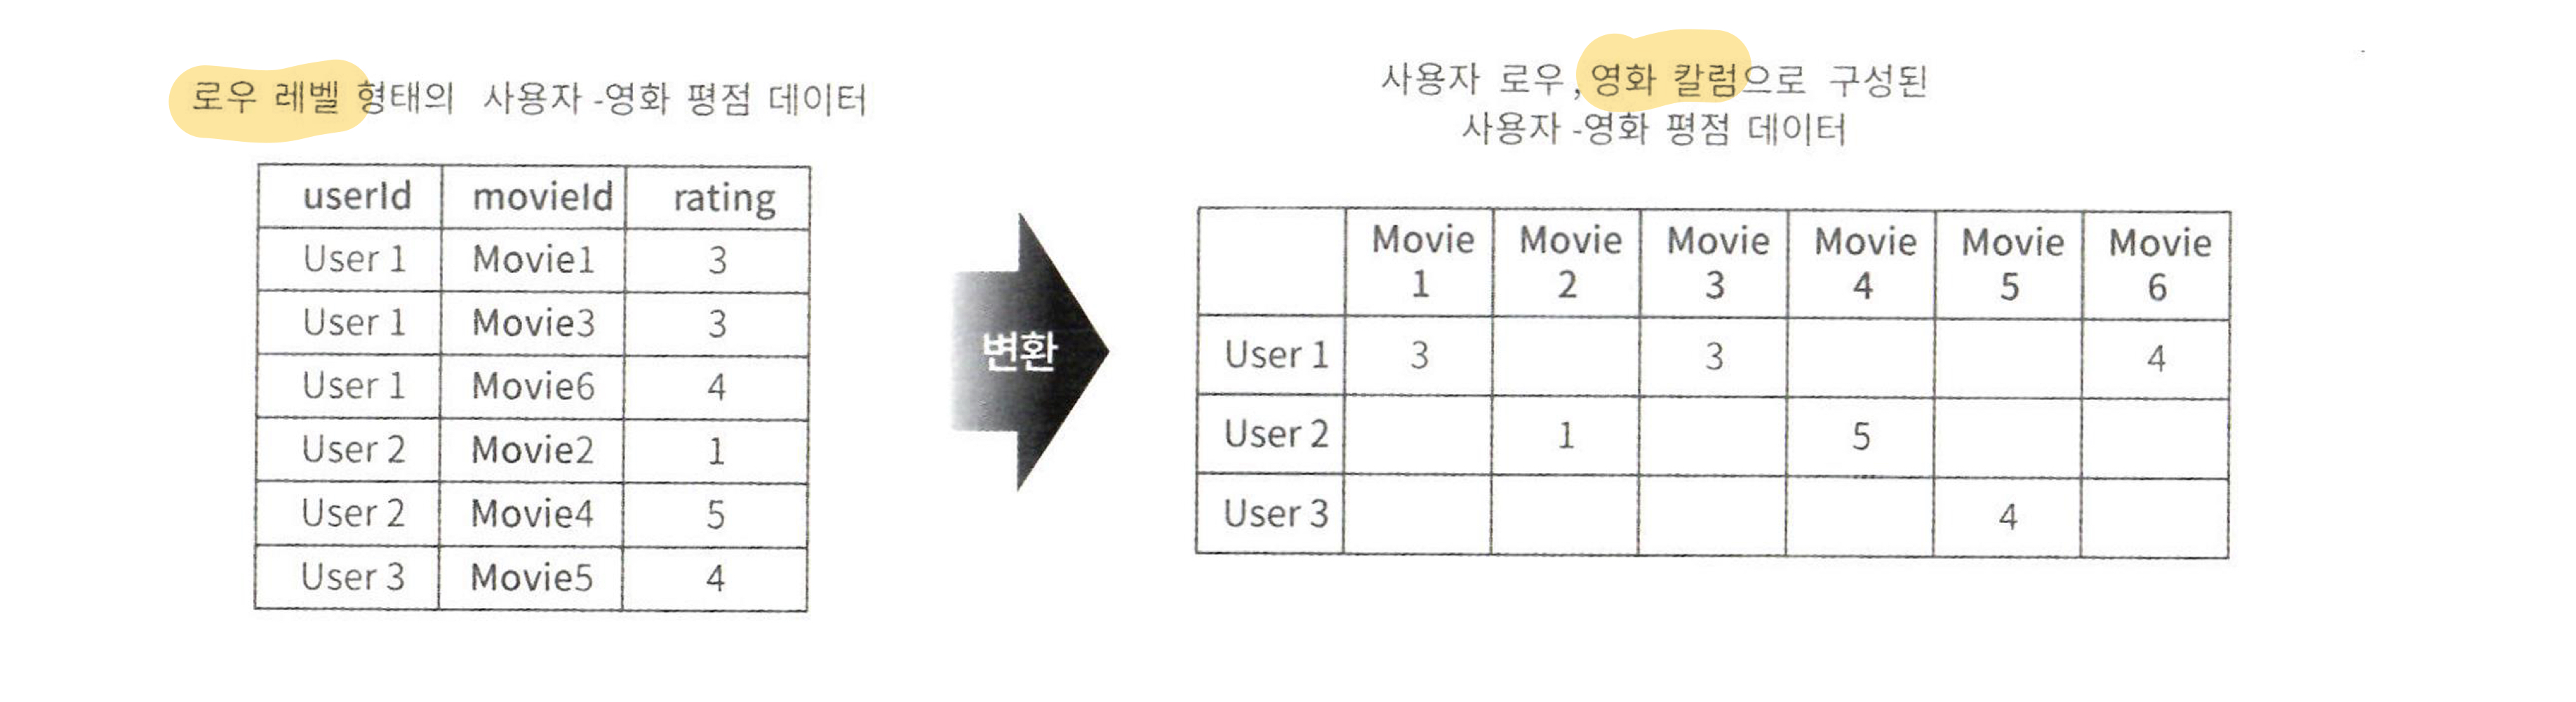

In [13]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# title 컬럼을 얻기 이해 movies 와 조인
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 피벗(pivot) 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0 으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2) 영화 간 유사도 산출

-코사인 유사도 기반 (행을 기준으로 다른 행과 비교하여 유사도 산출) 

=> 현재는 사용자간의 유사도가 만들어진다(행이 userID이므로)

In [22]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 영화명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                          columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.285169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65561,0.0,0.0,0.0,0.212814,0.919145,0.0,0.0,0.120996,0.0,0.0,0.0,0.149201,0.0,0.0,0.0,0.178042,0.0,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.715542,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150269,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.124109,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.148970,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,0.707107,0.505964,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106256,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.197457,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.105338,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [25]:
item_sim

array([[1.        , 0.        , 0.        , ..., 0.32732684, 0.        ,
        0.        ],
       [0.        , 1.        , 0.70710678, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.70710678, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.32732684, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [26]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

In [27]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

## 3) 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천

In [28]:
def predict_rating(ratings_arr, item_sim_arr ):
    ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [29]:
ratings_pred = predict_rating(ratings_matrix.values , item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,0.119402,0.185026,0.269199,0.521031,0.141683,0.116623,0.135441,0.224885,0.226528,0.113608,0.185277,0.303638,0.113608,0.255040,0.260446,0.326968,0.305769,0.155031,0.348717,0.186870,0.119402,0.099756,0.206331,0.348717,0.267407,0.237128,0.050947,0.050947,0.200747,0.156893,...,0.186554,0.050947,0.040443,0.121184,0.178482,0.104488,0.104488,0.110808,0.102542,0.175859,0.179162,0.231606,0.093467,0.094357,0.112690,0.113608,0.164231,0.086360,0.277215,0.262709,0.180320,0.112690,0.111653,0.130131,0.248312,0.132009,0.285913,0.113608,0.155861,0.155927,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,0.000000,0.005220,0.093722,0.000000,0.014296,0.016398,0.043685,0.019004,0.020071,0.015640,0.028349,0.043477,0.015640,0.019634,0.016893,0.008251,0.010919,0.013711,0.000000,0.020300,0.000000,0.002726,0.022639,0.000000,0.032268,0.031130,0.040699,0.040699,0.024950,0.043495,...,0.021269,0.040699,0.030610,0.019721,0.002215,0.023352,0.023352,0.028403,0.002314,0.006791,0.033143,0.010933,0.018806,0.003525,0.011425,0.015640,0.030904,0.017290,0.019250,0.039449,0.038895,0.011425,0.035400,0.038101,0.034181,0.026764,0.000000,0.015640,0.037980,0.006859,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,0.091413,0.007483,0.018710,0.080626,0.006995,0.006766,0.006988,0.005427,0.006743,0.006923,0.005389,0.008943,0.006923,0.008559,0.009333,0.006316,0.031652,0.007376,0.009832,0.022056,0.091413,0.002548,0.008762,0.009832,0.008773,0.004379,0.001117,0.001117,0.007007,0.005163,...,0.008810,0.001117,0.000000,0.010758,0.007362,0.003726,0.0

In [30]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 를 구함. 
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 인접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))

아이템 기반 모든 인접 이웃 MSE:  9.895354759094706


In [31]:

def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행 
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 index 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T) 
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))        
    return pred

In [32]:
ratings_pred = predict_rating_topsim(ratings_matrix.values , item_sim_df.values, n=20)
print('아이템 기반 인접 TOP-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))


# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

아이템 기반 인접 TOP-20 이웃 MSE:  3.6949827608772314


In [33]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[ user_rating_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Austin Powers in Goldmember (2002)                                                5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Producers, The (1968)                                                             5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Back to the Future (1985)                                                         5.0
Glengarry Glen Ross (1992)                                                        4.0
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)                                     4.0
Name: 9, dtype: float64

In [34]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듦
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 영화명을 list 객체로 만듦
    movies_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]
    
    return unseen_list

In [35]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출해서
    # 가장 예측 평점이 높은 순으로 정렬함
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies
    
# 사용자가 관람하지 않는 영화명 추출   
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


#9.7 행렬분해

In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [37]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0
       
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]
   
    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

In [39]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/gdrive/MyDrive/essa/9.6 영화 movielens latest datasets/movies.csv')
ratings = pd.read_csv('/content/gdrive/MyDrive/essa/9.6 영화 movielens latest datasets/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [40]:
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.20685455302331543
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720403
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.1669518194687172
### iteration step :  130  rmse :  0.1630529219199754
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.1545339818671543
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rmse

In [41]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,1.623927,3.910138,4.775403,3.837260,3.875488,1.550801,2.929129,2.680321,3.225626,3.251925,2.778350,3.331543,2.391855,3.199047,4.148949,1.852731,3.269642,3.448719,4.458060,3.719499,3.231820,3.521511,3.866924,3.961768,4.957933,4.075665,3.509040,3.923190,3.210152,4.374122,...,3.546313,3.207635,2.082641,3.302390,1.821505,3.814172,4.227119,3.699006,3.009256,4.605246,4.712096,4.284418,3.095067,3.214574,0.990303,1.805794,4.588016,2.295002,4.173353,0.327724,4.817989,1.902907,3.557027,2.881273,3.766529,2.703354,2.395317,2.373198,4.749076,4.281203,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,1.489588,3.617857,3.785199,3.168660,3.537318,0.995625,3.969397,2.173005,3.464055,2.475622,3.413724,2.665215,1.828840,3.322109,2.654698,1.469953,3.035060,3.163879,4.244324,2.727754,2.879571,3.124665,3.773794,3.774747,3.175855,3.458016,2.923885,3.303497,2.806202,3.504966,...,3.289954,2.677164,2.087793,3.388524,1.783418,3.267824,3.661620,3.131275,2.475330,3.916692,4.197842,3.987094,3.134310,2.827407,0.829738,1.380996,3.974255,2.685338,3.902178,0.293003,3.064224,1.566051,3.095034,2.769578,3.956414,2.493763,2.236924,1.775576,3.909241,3.799859,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,0.881095,1.813452,2.687841,1.908641,2.228256,0.695248,1.146590,1.536595,0.809632,1.561342,1.820714,1.097596,1.216409,1.347617,1.760926,0.622817,1.786144,1.934932,2.332054,2.291151,1.983643,1.785523,2.265654,2.055809,2.459728,2.092599,2.512530,2.928443,1.777471,1.808872,...,1.779506,2.222377,1.448616,2.340729,1.658322,2.231055,2.6

In [42]:
# 사용자가 관람하지 않는 영화명 추출   
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690
